TODO: Clean up this file to better walk the user through the steps...

For now, just want completed file that utilizes the inverse covariance module from the corrcal_gpu_pipeline

In [19]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    print(f"Added {parent_dir} to sys.path")
else:
    print(f"{parent_dir} is already in sys.path")

/home/mike/corrcal_gpu_pipeline is already in sys.path


In [20]:
from pipeline.invcov import *

# Inverse Covariance Validation Tests 

Let's perform some tests to ensure that the components we are calculating really do make up the inverse noise and the primed versions of the delta and sigma matrices. 

In [29]:
#the main parametes describing our problem.
n_bl = 50
n_eig = 3
n_src = 6
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 10))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")

#some random noise, diffuse, and source covariance matrices
sim_noise_mat = xp.random.rand(n_bl, dtype = 'float64')**2   #in principle this is squared since is a variance
sim_diff_mat = xp.random.rand(n_bl, n_eig, dtype = 'float64')
sim_src_mat = xp.random.rand(n_bl, n_src, dtype = 'float64')

#actually go and find inverse components
N_inv, Del_p, Sig_p = inverse_covariance(sim_noise_mat, sim_diff_mat, sim_src_mat, edges=edges, xp = xp)

#convert sparse things to dense things to visualize what we're really working with
sim_diff_mat_dense = sparden_convert(sim_diff_mat, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)
Del_p_dense = sparden_convert(Del_p, n_bl=n_bl, n_eig=n_eig, edges=edges, xp = cp)

The edges of the redundant blocks have indices[ 0  1 19 24 27 30 37 40 43 45 47 50]


Let's visualize the desnse version of the diffuse matrix. Of course, in reality all entries within each redundant block will be equal. Though since we're beginning with random numbers, we expect the dense diffuse matrix to have a general block diagonal shape with random numbers within each block. Let's see what this looks like below. 

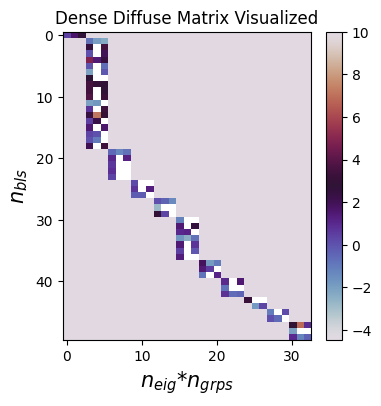

In [36]:
fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(cp.asnumpy(cp.log(Del_p_dense + 1e-20)*-1), vmax = 10, cmap='twilight', aspect='auto')
ax.set_title("Dense Diffuse Matrix Visualized")
ax.set_xlabel("$n_{eig}$*$n_{grps}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()

#would like the center to be at 0, vmin and vmax only differ by a sign

For validating the correctness of our actual $C^{-1}$ routine, let's run the following cell block.

In [23]:
#First we assemble te dense covariance object using the input matrices above
C = xp.diag(sim_noise_mat) + sim_diff_mat_dense@sim_diff_mat_dense.T + sim_src_mat@sim_src_mat.T

#Now we do the same with the inverse covariance components
C_inv = xp.diag(N_inv) - Del_p_dense@Del_p_dense.T - Sig_p@Sig_p.T

#now check their matrix product returns the identity
if np.allclose(C@C_inv, np.eye(C.shape[0])) == True:
    print("C*C^{-1} returns the identity")

#brute force computation of C^{-1} using numpy
C_numpy_inv = cp.linalg.inv(C)

#check the answer is the same as C = N + Del * Del^dag + Sig * Sig^dag 
if np.allclose(C_inv, C_numpy_inv) == True:
    print("Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine")


C*C^{-1} returns the identity
Brute force computation with numpy returns the same answer as our sparse 2-level inverse routine


So it looks like both checks verify our solution found by manually computing $N$, $\Delta'$, and $\Sigma'$ and assembling $C^{-1}$ ourselves is the correct one. However, just for fun we can visualize the result of $CC^{-1}$ to be sure that what we're getting really is the identity.

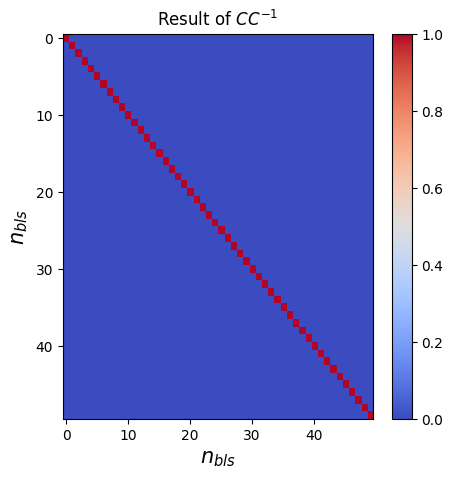

In [24]:
fig, ax = plt.subplots(figsize = (5,5))
im = ax.imshow(cp.asnumpy(C@C_inv), cmap = 'coolwarm', aspect='auto')
ax.set_title("Result of $CC^{-1}$")
ax.set_xlabel("$n_{bls}$", fontsize = 15)
ax.set_ylabel("$n_{bls}$", fontsize = 15)
fig.colorbar(im)
plt.show()